# Estimate Paramters of system of ODEs for given time course data

imports

In [1]:
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver
from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting
import matplotlib.pyplot as plt # plot data and results

### Get data from excel

In [2]:
data = './datasets/Michaelis menten Hannah.xlsx'
df = pd.read_excel(data, sheet_name=1)

### Convert dataframe to np-array

In [3]:
cutting = -15
# time:
data_time = df[df.columns[0]].to_numpy(np.float64) #shape: (21,)
data_time = data_time[:cutting]
print(data_time.shape)
# substrate data (absorption):
data_s = np.transpose(df.iloc[:cutting,1:-2].to_numpy(np.float64)) #shape for df.iloc[:,1:-2]: (7, 21)
print(data_s.shape)

(6,)
(7, 6)


## Fit data to system of odes

### define the ode functions

In [4]:
def f(w, t, paras):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = s
        t: time
        params: parameters
    '''
    s = w
    
    try:
        vmax = paras['vmax'].value
        km = paras['Km'].value

    except TypeError:
        vmax, km = paras
    
    
    f1 = -vmax*s/(km+s) # s'
    return f1

### Solve ODE

In [5]:
def g(t, w0, paras):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [s0])
    '''
    w = odeint(f, w0, t, args=(paras,))
    return w

### compute residual between actual data (s) and fitted data

In [6]:
def res_multi(params, t, data_s):
    ndata, nt = data_s.shape
    resid = 0.0*data_s[:]
    # residual per data set
    for i in range(ndata):
        w0 = data_s[i,0]
        model = g(t, w0, params)
        s_model = model[:,0]
        resid[i,:]=data_s[i,:]-s_model
    return resid.flatten()

In [7]:
def get_v(time, data_s):
    v_all = 0.0*data_s[:] # initialize velocity vector
    if len(data_s.shape)>1:
        for i in range(data_s.shape[0]):
            prev_value = data_s[i,0]
            prev_time = 0.0
            for j in range(data_s.shape[1]):
                if time[j] == 0:
                    delta = prev_value - data_s[i,j]
                else:
                    delta = abs( (prev_value - data_s[i,j])/(time[j]-prev_time))
                v_all[i,j] = delta
                prev_value = data_s[i,j]
                prev_time = time[j]
        v = np.max(v_all, axis=0)
    else:
        prev_value = data_s[0]
        prev_time = 0.0
        for j in range(data_s.shape[0]):
            if time[j] == 0:
                delta = prev_value - data_s[j]
            else:
                delta = abs( (prev_value - data_s[j])/(time[j]-prev_time))
            v_all[j] = delta
            prev_value = data_s[j]
            prev_time = time[j]
        v = v_all
    return v

In [8]:
def get_initial_vmax(time, data_s):
    v = get_v(time,data_s)
    return np.max(v)

In [9]:
def get_initial_Km(time, data_s):
    v = get_v(time,data_s)
    idx_max = np.where(v == np.max(v))[0][0]
    idx_Km = (np.abs(v[idx_max:]-np.max(v)/2)).argmin()
    if len(data_s.shape)>1:
        km = np.mean(data_s,axis=0)[idx_max+idx_Km]
    else:
        km = data_s[idx_max+idx_Km]
    return km

### Bringing everything together
Initialize parameters

In [10]:
# time
t_measured = data_time

# initial conditions:
if len(data_s.shape)>1:
    s0 = np.max(data_s,axis=0)[0]
else:
    s0 = data_s[0]

# Set parameters including bounds
vmax = get_initial_vmax(t_measured, data_s)
km = get_initial_Km(t_measured, data_s)

params = Parameters()
params.add('vmax', value=0.1, min=0.0001, max=100.)
params.add('Km', value=km, min=0.0001, max=s0)

Fit model and visualize results

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 104
    # data points      = 42
    # variables        = 2
    chi-square         = 0.03967069
    reduced chi-square = 9.9177e-04
    Akaike info crit   = -288.522112
    Bayesian info crit = -285.046773
[[Variables]]
    vmax:  1.49364484 +/- 0.40797972 (27.31%) (init = 0.1)
    Km:    0.98039216 +/- 0.16056728 (16.38%) (init = 0.1334047)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) =  0.996


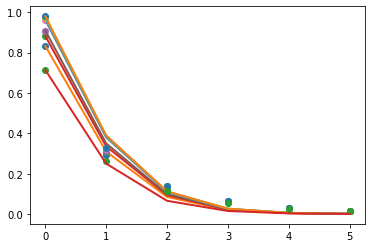

In [11]:
if len(data_s.shape)>1:
    result = minimize(res_multi , params, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    for i in range(data_s.shape[0]):
        plt.plot(t_measured, data_s[i, :], 'o')
        w0 = data_s[i,0]
        data_fitted = g(t_measured, w0, result.params)
        plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()
else: # TODO
    result = minimize(residual_single , params, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    plt.plot(t_measured, data_s[:], 'o')
    w0 = data_s[0]
    data_fitted = g(t_measured, w0, result.params)
    plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()

In [12]:
vmax = result.params['vmax'].value
km = result.params['Km'].value

0.6862692491183534
0.7075159750958543
0.7186404401123427
0.7395717150656341
0.7436976381619498
0.7468224181540103
0.6295527822523823


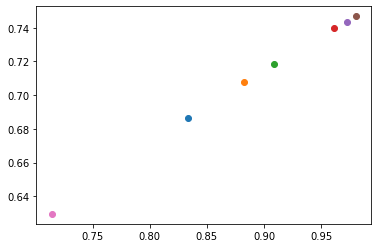

In [13]:
for i in range(7):
    v0=-f(data_s[i,0],t_measured,[vmax,km])
    print(v0)
    plt.plot(data_s[i,0],v0,'o')

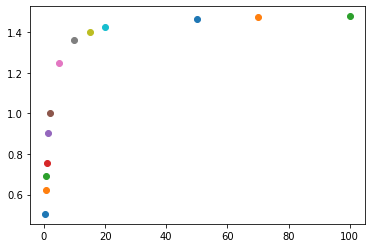

In [14]:
s_init = [0.5,0.7,0.85,1,1.5,2,5,10,15,20,50,70,100]
for s in s_init:
    v0=-f(s,t_measured,[vmax,km])
    plt.plot(s,v0,'o')

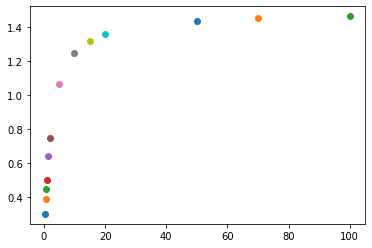

In [15]:
s_init = [0.5,0.7,0.85,1,1.5,2,5,10,15,20,50,70,100]
for s in s_init:
    v0=-f(s,t_measured,[vmax,2])
    plt.plot(s,v0,'o')